In [1]:
import sys
import imp
import os
os.chdir("/Users/oliver/YOGA/Yoga/Personal/Oliver/")
sys.path.append("/Users/oliver/YOGA/Yoga/Personal/Oliver/")
sys.path.insert(0, "/Users/oliver/YOGA/Yoga/Personal/Oliver/")
funcs = imp.load_source('functions', '/Users/oliver/YOGA/Yoga/Personal/Oliver/files/functions.py')

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import functions as funcs
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def fill_nan_in_matrix(X, value):
    ix_list = np.argwhere(np.isnan(X)).tolist()
    for ix in ix_list:
        X[ix[0], ix[1]] = value


def get_sentiment_features_df(ROOT_PATH, str):
    if (str == 'train'):
        fname = 'train_sentiment_features.csv'
    elif (str == 'test'):
        fname = 'test_sentiment_features.csv'
    train_sentiment_raw = pd.read_csv(os.path.join(
        ROOT_PATH, "Data", fname),
        delimiter=';').iloc[:, [0, 1, 2, 3]]
    df = train_sentiment_raw.copy()
    df = pd.concat([df, pd.get_dummies(df['amazon_sentiment'])], axis=1).rename(
        columns={'POSITIVE': 'az_positive',
                 "NEGATIVE": 'az_negative',
                 "NEUTRAL": 'az_neutral'}).drop('amazon_sentiment', axis=1)

    return df


def count_features_and_scale(df, df_counts):
    scaler = StandardScaler()
    counts = df[['retweet_count', 'favorite_count']].apply(lambda x: x + 1)
    counts['counts_emoticons'] = df_counts.emoticons.apply(lambda x: x + 1)
    counts['counts_hashtags'] = df_counts.hashtags.apply(lambda x: x + 1)
    counts['counts_mentions'] = df_counts.mentions.apply(lambda x: x + 1)
    counts['counts_words'] = df_counts.words.apply(lambda x: x + 1)
    counts = np.log10(counts)
    features_counts = scaler.fit_transform(counts)
    features_counts = pd.DataFrame(features_counts)

    return features_counts


def remove_tweets_with_non_identified_language(df):
    df.drop(df[(df['language_id'] == 'lb') |
               (df['language_id'] == 'co') |
               (df['language_id'] == 'mr')].index, inplace=True)
    df.reset_index(inplace=True, drop=True)

    return df


def get_features_of_interest_counts(df):
    return pd.DataFrame({'words': df['text'].apply(lambda x: funcs.number_words(x)),
                         'emoticons': df['text'].apply(lambda x: funcs.number_emoticons(x)),
                         'hashtags': df['text'].apply(lambda x: funcs.number_hashtags(x)),
                         'mentions': df['text'].apply(lambda x: funcs.number_mentions(x)),
                         })


def get_language_df(df):
    return pd.DataFrame({'ca': np.where(df['language_id'] == 'ca', 1, 0),
                         'es': np.where(df['language_id'] == 'es', 1, 0),
                         'en': np.where(df['language_id'] == 'en', 1, 0),
                         'other': df['language_id'].apply(lambda x: 1 if x not in {'ca', 'es', 'en'} else 0)
                         })


def add_text_clean_col_to_df(df):
    df['text_clean'] = df['traducciones'].apply(lambda x: funcs.clean_text(x))

    return df

def get_day_week(df):
    df.created_at = pd.to_datetime(df.created_at)
    day_week = df['created_at'].dt.day_name()
    ohe = OneHotEncoder(handle_unknown='ignore')
    day_week = np.array(day_week)
    day_week = day_week.reshape(-1, 1)
    day_week = ohe.fit_transform(day_week).toarray()
    return pd.DataFrame(day_week)

def get_part_day(df):
    new_hours = df.created_at[df.created_at.dt.hour == 0]
    new_hours2 = new_hours + dt.timedelta(hours=1)
    df.created_at[df.created_at.dt.hour == 0] = new_hours2
    part_day = pd.cut(df.created_at.dt.hour,[0,6,12,18,24],labels=['Night','Morning','Afternoon','Evening'])
    ohe = OneHotEncoder(handle_unknown='ignore')
    part_day = np.array(part_day)
    part_day = part_day.reshape(-1, 1)
    part_day = ohe.fit_transform(part_day).toarray()
    return pd.DataFrame(part_day)

In [8]:
if __name__ == '__main__':
    # SET PATHS ##
    ROOT_PATH = "/Users/oliver/YOGA/Yoga/"
    PERSONAL_PATH = "Personal/Oliver"

    os.chdir(os.path.join(ROOT_PATH, PERSONAL_PATH))
    sys.path.append(os.path.join(ROOT_PATH, PERSONAL_PATH))
    TRAIN_FPATH = os.path.join(ROOT_PATH, "Data/train_traducido.csv")
    TEST_FPATH = os.path.join(ROOT_PATH, "Data/test_traducido.csv")

    ## Load data and Preprocess Data ##
    train_df_tr = pd.read_csv(TRAIN_FPATH, delimiter=';')
    train_df_tr = remove_tweets_with_non_identified_language(train_df_tr)
    train_df_tr = add_text_clean_col_to_df(train_df_tr)
    
    train_df_sentiment = get_sentiment_features_df(ROOT_PATH, str='train') # load sentiment
    train_df_tr = pd.concat([train_df_tr, train_df_sentiment], axis=1)
    #train_df_tr.created_at = pd.to_datetime(train_df_tr.created_at)

/Users/oliver/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


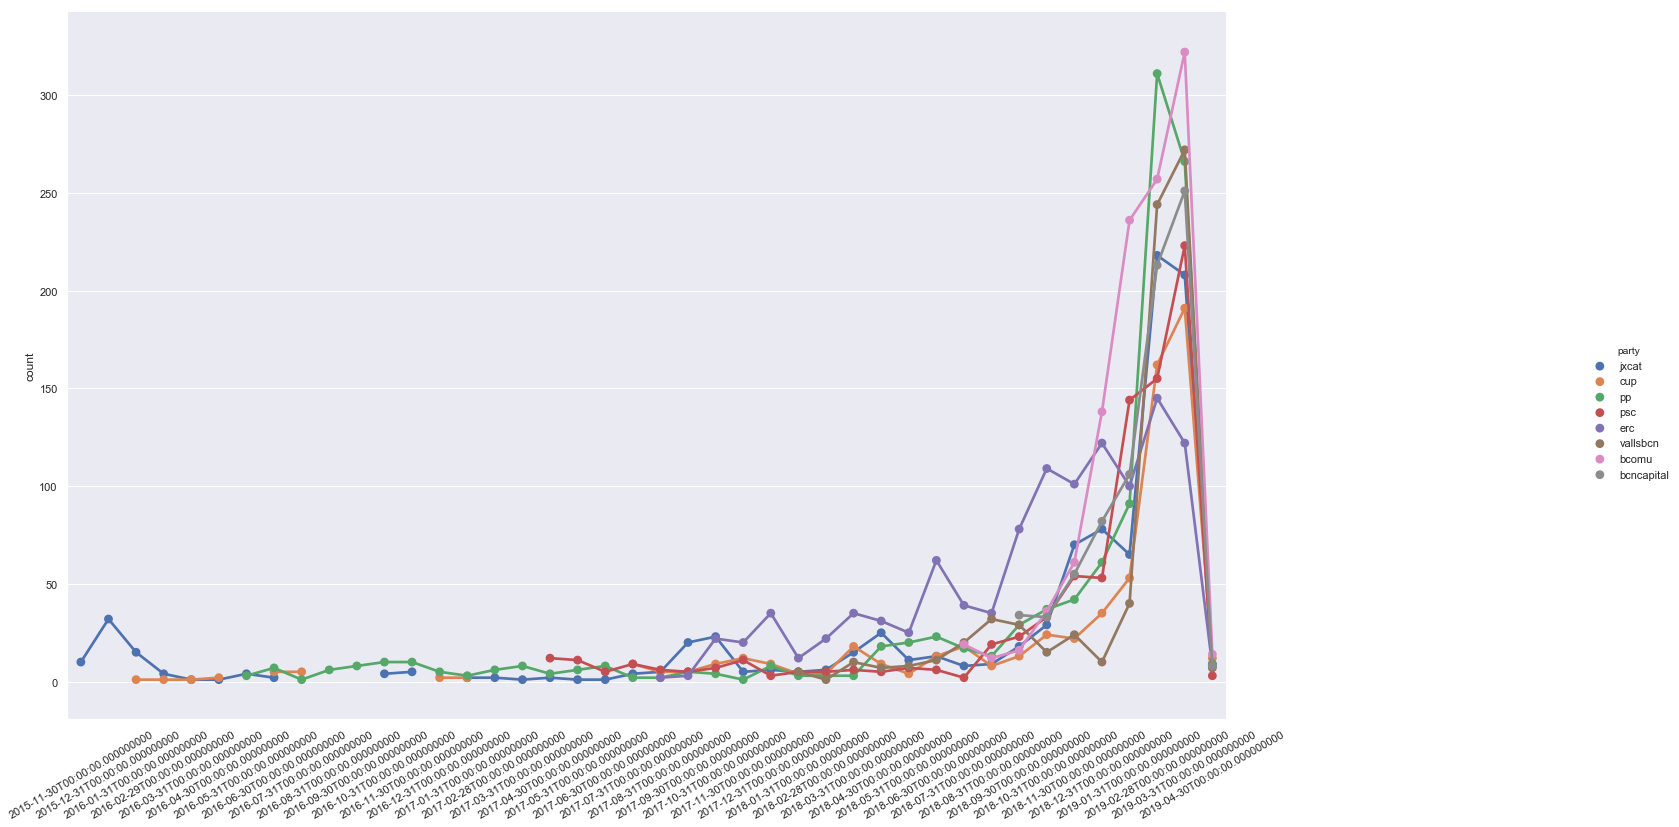

In [9]:
def create_plot5(feature1, feature2, feature_color, freq_time, tipo, tipo_aggr, transparency, ancho, largo):
    '''
    feature 1: 'created_at'
    feature 2: 'google_sentiment', 'azure_sentiment'
    freq_time = 'M', 'Y', ...
    tipo = 'point',  ...
    tipo_aggr = 'count', 'mean' .. (alguna func que previamente se haya aggr)
    transparency = 0.1, 0.2 ...
    ancho = 30,...
    largo = 12,..
    ej: create_plot5('created_at', 'google_sentiment', 'party', 'M', 'point', 0.1, 30, 12)
    '''
    x = feature1
    y = feature2
    
    list_of_series = [train_df_tr[x], train_df_tr[y], train_df_tr[feature_color]]
    col_names = [x,y,feature_color]
    df = pd.DataFrame(list_of_series, columns=col_names)
    df = pd.concat(list_of_series, axis=1)
    
    df.created_at = pd.to_datetime(df.created_at)
    df = df.groupby([pd.Grouper(key='created_at', freq=freq_time),
                     pd.Grouper(key=feature_color)]).agg(['count', 'mean'])
    
    b = df.stack(level=0).reset_index()
            
    sns.set()
    fg = sns.factorplot(x=feature1, 
                        y=tipo_aggr, 
                        hue=feature_color, 
                        data=b, kind='point',
                        plot_kws={
                                  'points_kws': {'alpha': transparency}})
    fg.set_xlabels('')
    fg.set_xticklabels(rotation=30)
    fig, ax = fg.fig, fg.ax
    fig.set_size_inches(ancho, largo)
    if tipo_aggr == 'mean':
        ax.axhline(0.5, ls='--')
    return plt.show()

create_plot5('created_at', 'google_sentiment', 'party', 'M', 'point', 'count', 0.1, 30, 12)

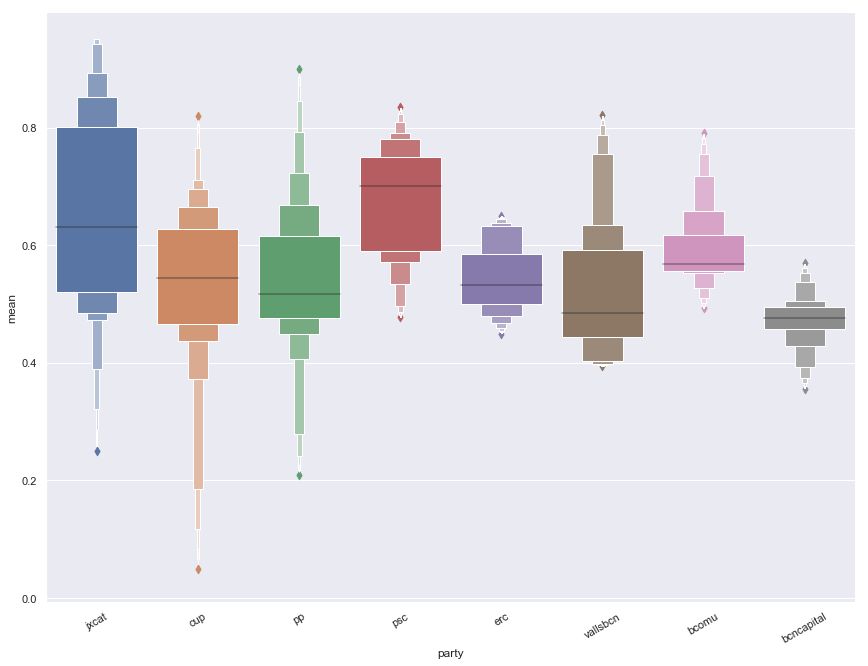

In [7]:
x = 'created_at'
y = 'google_sentiment'
feature_color = 'party'
lista = list(np.unique(train_df_tr[feature_color]))
list_of_series = [train_df_tr[x], train_df_tr[y], train_df_tr[feature_color]]
col_names = [x, y, feature_color]
df = pd.DataFrame(list_of_series, columns=col_names)
df = pd.concat(list_of_series, axis=1)
df.created_at = pd.to_datetime(df.created_at)
df = df.groupby([pd.Grouper(key='created_at', freq='M'),
                pd.Grouper(key='party')]).agg(['count', 'mean'])
b = df.stack(level=0).reset_index()

fg = sns.catplot(x="party", y="mean", kind="boxen",
                     data=b)
fg.set_xticklabels(rotation=30)
fig = fg.fig
fig.set_size_inches(14, 10)

Text(0.5, 1.0, 'From 2018-10-01 to 2019-04-30')

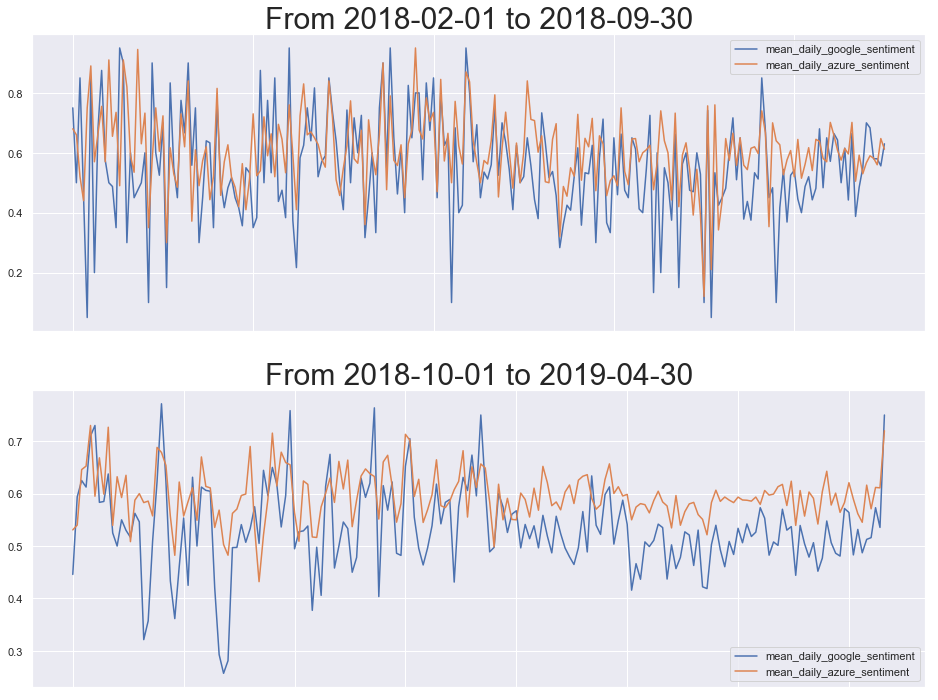

In [29]:
f = {'google_sentiment': 'mean',
     'azure_sentiment': 'mean'
     }
f_df = train_df_tr[['created_at', 'party', 'azure_sentiment', 'google_sentiment']]
f_df.created_at = pd.to_datetime(f_df.created_at)
f_df = f_df.set_index('created_at')

date1_start = '2018-02-01'
date1_end = '2018-09-30'
f_df1 = f_df.loc[date1_start:date1_end]
f_df1 = f_df1.groupby([lambda x: x.year, lambda x: x.month, lambda x: x.day]) \
    .agg(f) \
    .rename(columns={  # 'party': 'count',
    'google_sentiment': 'mean_daily_google_sentiment',
    'azure_sentiment': 'mean_daily_azure_sentiment'})

date2_start = '2018-10-01'
date2_end = '2019-04-30'
f_df2 = f_df.loc[date2_start:date2_end]
f_df2 = f_df2.groupby([lambda x: x.year, lambda x: x.month, lambda x: x.day]) \
    .agg(f) \
    .rename(columns={  # 'party': 'count',
    'google_sentiment': 'mean_daily_google_sentiment',
    'azure_sentiment': 'mean_daily_azure_sentiment'})

fig, axes = plt.subplots(nrows=2, ncols=1)
fig.set_size_inches(16, 12)
ax1 = f_df1.plot(ax=axes[0])
ax2 = f_df2.plot(ax=axes[1])
ax1.set_title('From ' + date1_start + ' to ' +  date1_end, fontsize=30)
ax2.set_title('From ' + date2_start + ' to ' +  date2_end, fontsize=30)

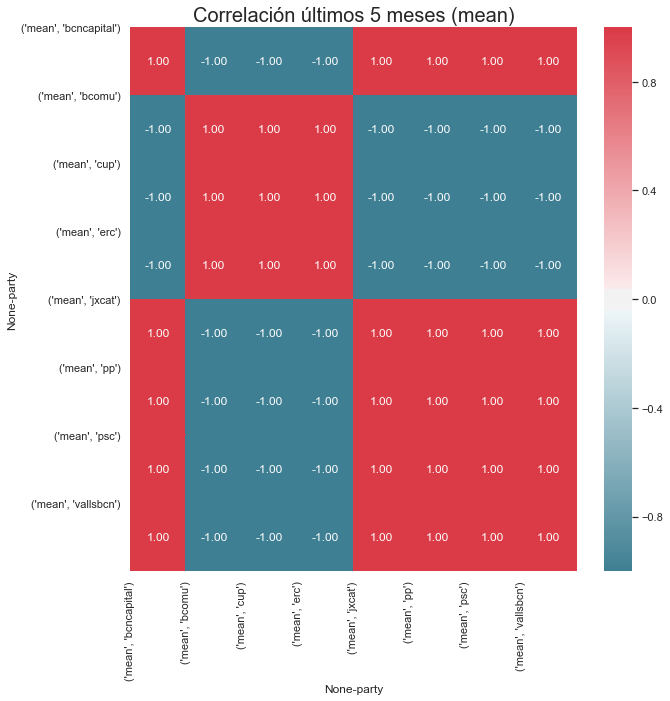

In [27]:
def heatMap(df, kind):
    
    corr = df.corr()
    fig, ax = plt.subplots(figsize=(10, 10))
    #Generate Color Map
    colormap = sns.diverging_palette(220, 10, as_cmap=True)
    #Generate Heat Map, allow annotations and place floats in map
    sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f")
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.title('Correlación últimos 5 meses ({})'.format(kind),fontsize=20)
    plt.show()
    
    
def heatmap_full(df, sinceWhen, freq_time, sentiment, kind_agg):
    
    '''
    df: pass the train_df
    sinceWhen: '2018-09', '2017-12', etc
    freq_time: 'M', 'W-MON', ...
    sentiment: "azure_sentiment" or "google_sentiment"
    kind_agg: 'mean' or 'count'
    ej: heatmap_full(train_df_tr, '2018-09', 'M', "azure_sentiment", 'mean')
    '''       
    #Reshaping of df
    df.created_at = pd.to_datetime(df.created_at)
    df = df[df['created_at'] >= sinceWhen]
    df1 = df.groupby([pd.Grouper(key='created_at', freq=freq_time),
                 pd.Grouper(key='party')]).agg(['count', 'mean'])
    df1 = df1.stack(level=0).reset_index()
    df1_1 = df1[(df1.level_2 == sentiment)]
    df1_1 = df1_1.filter(items=['created_at','party',kind_agg])
    df1_1 = df1_1.pivot(index='created_at', columns='party')
    return heatMap(df1_1, kind_agg)

heatmap_full(train_df_tr, '2019-03', 'M', "azure_sentiment", 'mean')